# Figures 

## SOSE

In [1]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline
import gsw
from fastjmd95 import jmd95numba
from fastjmd95 import rho, drhods, drhodt
import json

In [2]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [3]:
omega_total = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/wmt_budget_terms/omega_total_newbins.zarr'))
R1 = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/wmt_budget_terms/R1_newbins.zarr'))

In [4]:
wmt_budget_terms = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/wmt_budget_terms/wmt_budget_terms_newbins.zarr'))
wmt_budget_terms['omega_total'] = omega_total.omega_total
wmt_budget_terms['R1'] = R1.R1
wmt_budget_terms = wmt_budget_terms.sel(time=slice('2006', '2010'))

wmt_budget_terms.load()

<xarray.Dataset>
Dimensions:               (time: 366, sigma2_bin: 99)
Coordinates:
  * time                  (time) datetime64[ns] 2006-01-01 ... 2010-12-31
  * sigma2_bin            (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03
Data variables: (12/24)
    R1                    (time, sigma2_bin) float64 -7.392e+06 ... 0.0
    R1_slt                (time, sigma2_bin) float64 -1.15e+07 ... 0.0
    R1_th                 (time, sigma2_bin) float64 -1.319e+07 ... 0.0
    R2                    (time, sigma2_bin) float64 7.816e+06 8.187e+06 ... 0.0
    R2_slt                (time, sigma2_bin) float64 7.839e+06 8.74e+06 ... 0.0
    R2_th                 (time, sigma2_bin) float64 -9.438e+05 ... 0.0
    ...                    ...
    omega_total_th        (time, sigma2_bin) float64 -8.895e+06 ... 0.0
    omega_trans_rate      (time, sigma2_bin) float32 -2.822e+07 ... 0.0
    omega_trans_rate_slt  (time, sigma2_bin) float32 -1.935e+07 ... 0.0
    omega_trans_rate_th   (time, sigma2_bin) float32 -8.872e+06 ... 0.0
    psi_adv               (time, sigma2_bin) float32 8.737e+06 8.911e+06 ... 0.0
    psi_vel               (time, sigma2_bin) float64 9.212e+05 ... -0.0

In [5]:
#indices
indices = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/indices.zarr')).load()
deep = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/deep.zarr')).load()
bottom = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/bottom.zarr')).load()

#climatology ds
clim = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/clim_ds.zarr')).load()
#anomalous ds
anom = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/anom_ds.zarr')).load()

## Time mean budgets

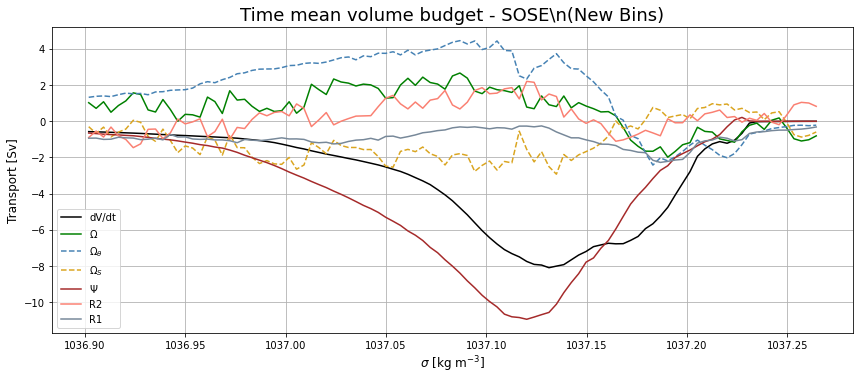

In [6]:
(wmt_budget_terms.dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', figsize=(12,5))
(wmt_budget_terms.omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega$', color='green')
(wmt_budget_terms.omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', color='steelblue', linestyle='dashed')
(wmt_budget_terms.omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', color='goldenrod', linestyle='dashed')
(wmt_budget_terms.psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', color='brown')
(wmt_budget_terms.R2/1e6).mean(dim='time').plot(label='R2', color='salmon')
(wmt_budget_terms.R1/1e6).mean(dim='time').plot(label='R1', color='lightslategray')
#(R3[1:-1]/1e6).mean(dim='time').plot(label=r'$R3$', color='mediumspringgreen')
plt.legend()
plt.grid()
plt.tight_layout()
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
plt.ylabel(r'Transport [Sv]', fontsize=12)
plt.title(r'Time mean volume budget - SOSE\n(New Bins)', fontsize=18);

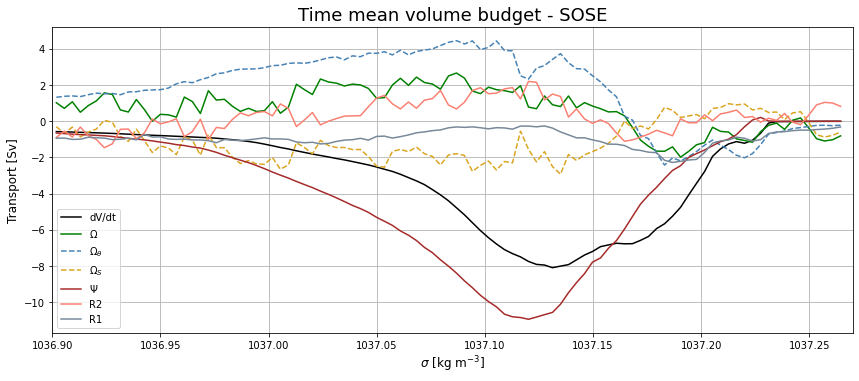

In [7]:
(wmt_budget_terms.dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', figsize=(12,5))
(wmt_budget_terms.omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega$', color='green')
(wmt_budget_terms.omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', color='steelblue', linestyle='dashed')
(wmt_budget_terms.omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', color='goldenrod', linestyle='dashed')
(wmt_budget_terms.psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', color='brown')
(wmt_budget_terms.R2/1e6).mean(dim='time').plot(label='R2', color='salmon')
(wmt_budget_terms.R1/1e6).mean(dim='time').plot(label='R1', color='lightslategray')
#(R3[1:-1]/1e6).mean(dim='time').plot(label=r'$R3$', color='mediumspringgreen')
plt.legend()
plt.grid()
plt.xlim(1036.90, 1037.27)
#plt.ylim(-12, 12)
plt.tight_layout()
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
plt.ylabel(r'Transport [Sv]', fontsize=12)
plt.title(r'Time mean volume budget - SOSE', fontsize=18);

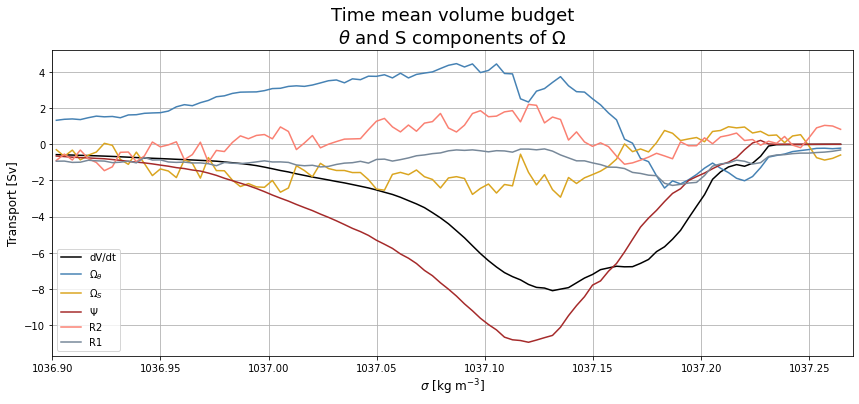

In [8]:
(wmt_budget_terms.dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', figsize=(12,5))
(wmt_budget_terms.omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', color='steelblue')
(wmt_budget_terms.omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', color='goldenrod')
(wmt_budget_terms.psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', color='brown')
(wmt_budget_terms.R2/1e6).mean(dim='time').plot(label='R2', color='salmon')
(wmt_budget_terms.R1/1e6).mean(dim='time').plot(label='R1', color='lightslategray')
#(R3[1:-1]/1e6).mean(dim='time').plot(label=r'$R3$', color='mediumspringgreen')
plt.legend()
plt.grid()
#plt.ylim(-12, 12)
plt.xlim(1036.90, 1037.27)
plt.tight_layout()
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
plt.ylabel(r'Transport [Sv]', fontsize=12)
plt.title("Time mean volume budget\n" r'$\theta$ and S components of $\Omega$', fontsize=18);

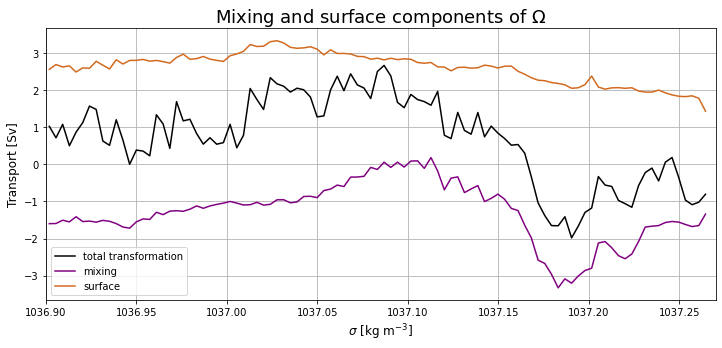

In [9]:
(wmt_budget_terms.omega_trans_rate/1e6).mean(dim='time').plot(figsize=(12,5), label='total transformation', color='k')#, marker='.')
(wmt_budget_terms.omega_mix/1e6).mean(dim='time').plot(label='mixing', color='purple')
(wmt_budget_terms.omega_surf/1e6).mean(dim='time').plot(label='surface', color='chocolate')
plt.legend()
plt.grid()
plt.xlim(1036.90, 1037.27)
#plt.ylim(-6, 6)
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
plt.ylabel(r'Transport [Sv]', fontsize=12)
plt.title(r'Mixing and surface components of $\Omega$', fontsize=18);

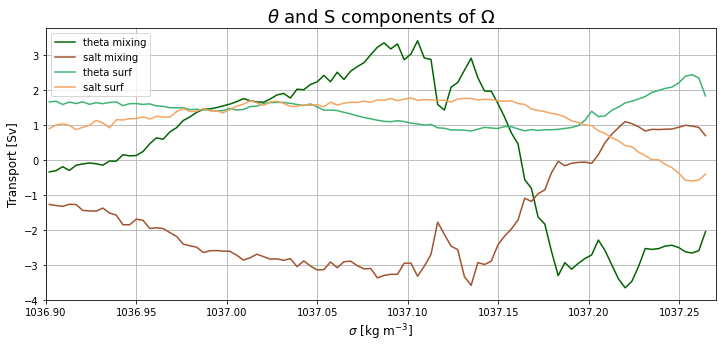

In [10]:
(wmt_budget_terms.omega_mix_th/1e6).mean(dim='time').plot(figsize=(12,5), label='theta mixing', color='darkgreen')
(wmt_budget_terms.omega_mix_slt/1e6).mean(dim='time').plot(label='salt mixing', color='sienna')
(wmt_budget_terms.omega_surf_th/1e6).mean(dim='time').plot(label='theta surf', color='mediumseagreen')
(wmt_budget_terms.omega_surf_slt/1e6).mean(dim='time').plot(label='salt surf', color='sandybrown')
plt.legend()
plt.grid()
plt.xlim(1036.90, 1037.27)
#plt.ylim(-10, 10)
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
plt.ylabel(r'Transport [Sv]', fontsize=12)
plt.title(r'$\theta$ and S components of $\Omega$', fontsize=18);

## Monthly Climatology

In [12]:
clim

<xarray.Dataset>
Dimensions:           (month: 12, sigma2_bin: 99)
Coordinates:
  * month             (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * sigma2_bin        (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03
Data variables:
    R1                (month, sigma2_bin) float64 -2.37 -2.077 ... -0.006441
    R2                (month, sigma2_bin) float64 -2.811 -2.8 ... 0.003102
    dVdt              (month, sigma2_bin) float64 -16.72 -16.59 ... -0.02164
    omega_mix         (month, sigma2_bin) float32 -6.315 -6.494 ... -0.01647
    omega_surf_slt    (month, sigma2_bin) float32 -2.003 -1.943 ... 0.0 0.0
    omega_surf_th     (month, sigma2_bin) float32 -4.877 -4.944 ... -0.008462
    omega_trans_rate  (month, sigma2_bin) float32 -12.68 -12.86 ... -0.02494
    psi_vel           (month, sigma2_bin) float64 -0.4061 -0.4329 ... 0.0 0.0

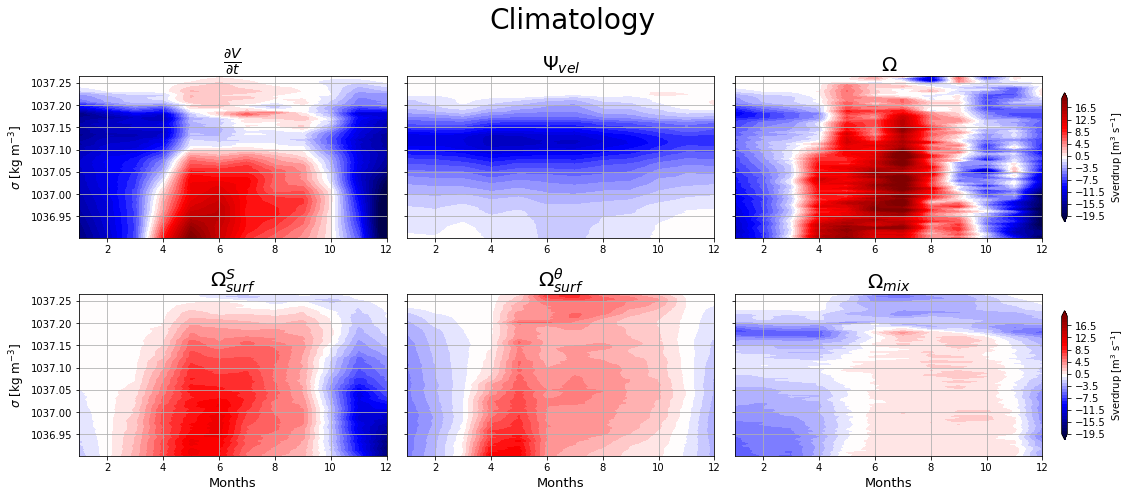

In [15]:
fig, ax = plt.subplots(2, 3, figsize=(16, 7), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})

levels = np.arange(-20, 20) + 0.5

c = ax[0,0].contourf(clim.dVdt.month, 
                   clim.dVdt.sigma2_bin, 
                   clim.dVdt.T, cmap='seismic', levels=levels, extend='both')
ax[0,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
ax[0,0].set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20)
ax[0,0].grid()

c_psi = ax[0,1].contourf(clim.psi_vel.month, clim.psi_vel.sigma2_bin, clim.psi_vel.T,
                         cmap='seismic', levels=levels, extend='both')
ax[0,1].set_title(r'$\Psi_{vel}$', fontsize=20)
ax[0,1].grid()

c_omega = ax[0,2].contourf(clim.omega_trans_rate.month, clim.omega_trans_rate.sigma2_bin, clim.omega_trans_rate.T,
                           cmap='seismic', levels=levels, extend='both')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[0,2])
ax[0,2].set_title(r'$\Omega$', fontsize=20)
ax[0,2].grid()

c_surf_slt = ax[1,0].contourf(clim.omega_surf_slt.month, 
                                clim.omega_surf_slt.sigma2_bin, 
                                clim.omega_surf_slt.T, cmap='seismic', levels=levels, extend='both')
ax[1,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
ax[1,0].set_xlabel('Months', fontsize=13)
ax[1,0].set_title('$\Omega^{S}_{surf}$', fontsize=20)
ax[1,0].grid()

c_surf_th = ax[1,1].contourf(clim.omega_surf_th.month, clim.omega_surf_th.sigma2_bin, 
                        clim.omega_surf_th.T, cmap='seismic', levels=levels, extend='both')
ax[1,1].set_xlabel('Months', fontsize=13)
ax[1,1].set_title(r'$\Omega^{\theta}_{surf}$', fontsize=20)
ax[1,1].grid()

c_mix = ax[1,2].contourf(clim.omega_mix.month, clim.omega_mix.sigma2_bin, clim.omega_mix.T, 
                        cmap='seismic', levels=levels, extend='both')
plt.colorbar(c_mix, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[1,2])
ax[1,2].set_xlabel('Months', fontsize=13)
ax[1,2].set_title(r'$\Omega_{mix}$', fontsize=20)
ax[1,2].grid()

plt.suptitle('Climatology', fontsize=28)
plt.tight_layout();

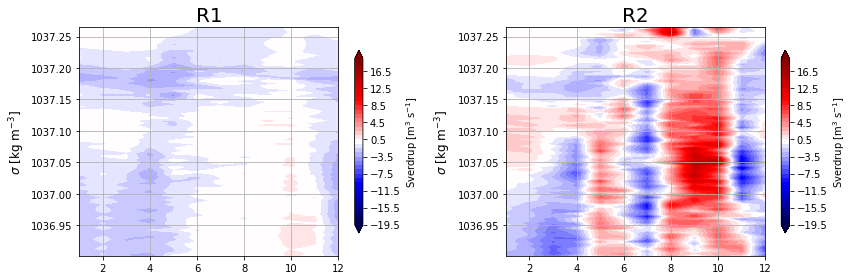

In [16]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

levels = np.arange(-20, 20) + 0.5

c = ax0.contourf(clim.R1.month, 
                   clim.R1.sigma2_bin, 
                   clim.R1.T, cmap='seismic', levels=levels, extend='both')
plt.colorbar(c, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax0)
ax0.set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
ax0.set_title('R1', fontsize=20)
ax0.grid()

c = ax1.contourf(clim.R2.month, 
                   clim.R2.sigma2_bin, 
                   clim.R2.T, cmap='seismic', levels=levels, extend='both')
plt.colorbar(c, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax1)
ax1.set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
ax1.set_title('R2', fontsize=20)
ax1.grid()

plt.tight_layout();

## Anomaly

In [17]:
anom

<xarray.Dataset>
Dimensions:           (time: 366, sigma2_bin: 99)
Coordinates:
  * sigma2_bin        (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03
  * time              (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-31
Data variables:
    R1                (time, sigma2_bin) float64 nan nan nan ... 0.3865 0.3141
    R2                (time, sigma2_bin) float64 nan nan nan ... -1.014 -0.8315
    dVdt              (time, sigma2_bin) float64 nan nan ... 0.001724 0.0008233
    omega_mix         (time, sigma2_bin) float32 nan nan nan ... 1.649 1.342
    omega_surf_slt    (time, sigma2_bin) float32 nan nan nan ... 0.5665 0.3989
    omega_surf_th     (time, sigma2_bin) float32 nan nan nan ... -2.348 -1.833
    omega_trans_rate  (time, sigma2_bin) float32 nan nan nan ... 1.024 0.8098
    psi_vel           (time, sigma2_bin) float64 nan nan nan nan ... 0.0 0.0 0.0

In [19]:
import warnings
warnings.filterwarnings("ignore")

In [20]:
year_start_index =[0,73, 146, 220, 293]

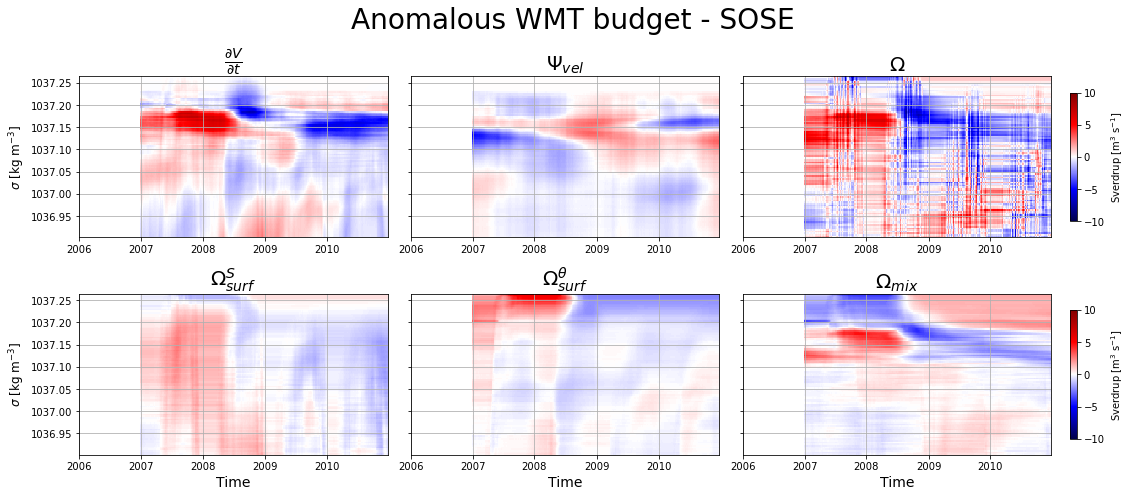

In [21]:
fig, ax = plt.subplots(2, 3, figsize=(16, 7), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})

c = ax[0,0].pcolormesh(anom.dVdt.time, 
                   anom.dVdt.sigma2_bin, 
                   anom.dVdt.T, vmin=-10, vmax=10, cmap='seismic')
ax[0,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
ax[0,0].set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20)
ax[0,0].set_xticks(anom.dVdt.time[year_start_index])
ax[0,0].set_xticklabels(np.arange(2006, 2011))
ax[0,0].grid()

c_psi = ax[0,1].pcolormesh(anom.psi_vel.time, anom.psi_vel.sigma2_bin, anom.psi_vel.T,
                        vmin=-10, vmax=10, cmap='seismic')
ax[0,1].set_title(r'$\Psi_{vel}$', fontsize=20)
#ax[0,1].set_ylim(1037.3, 1036.5)
ax[0,1].set_xticks(anom.dVdt.time[year_start_index])
ax[0,1].set_xticklabels(np.arange(2006, 2011))
ax[0,1].grid()

c_omega = ax[0,2].pcolormesh(anom.omega_trans_rate.time, anom.omega_trans_rate.sigma2_bin, anom.omega_trans_rate.T,
                        vmin=-10, vmax=10, cmap='seismic')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[0,2])
ax[0,2].set_title(r'$\Omega$', fontsize=20)
ax[0,2].set_xticks(anom.dVdt.time[year_start_index])
ax[0,2].set_xticklabels(np.arange(2006, 2011))
ax[0,2].grid()

c_surf_slt = ax[1,0].pcolormesh(anom.omega_surf_slt.time, 
                                anom.omega_surf_slt.sigma2_bin, 
                                anom.omega_surf_slt.T, vmin=-10, vmax=10, cmap='seismic')
ax[1,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
ax[1,0].set_xlabel('Time', fontsize=14)
ax[1,0].set_title('$\Omega^{S}_{surf}$', fontsize=20)
ax[1,0].set_xticks(anom.dVdt.time[year_start_index])
ax[1,0].set_xticklabels(np.arange(2006, 2011))
ax[1,0].grid()

c_surf_th = ax[1,1].pcolormesh(anom.omega_surf_th.time, anom.omega_surf_th.sigma2_bin, 
                        anom.omega_surf_th.T, vmin=-10, vmax=10, cmap='seismic')
ax[1,1].set_xlabel('Time', fontsize=14)
ax[1,1].set_title(r'$\Omega^{\theta}_{surf}$', fontsize=20)
#ax[1,1].set_ylim(1037.3, 1036.5)
ax[1,1].set_xticks(anom.dVdt.time[year_start_index])
ax[1,1].set_xticklabels(np.arange(2006, 2011))
ax[1,1].grid()

c_mix = ax[1,2].pcolormesh(anom.omega_mix.time, anom.omega_mix.sigma2_bin, anom.omega_mix.T, 
                        vmin=-10, vmax=10, cmap='seismic')
plt.colorbar(c_mix, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[1,2])
ax[1,2].set_xlabel('Time', fontsize=14)
ax[1,2].set_title(r'$\Omega_{mix}$', fontsize=20)
ax[1,2].set_xticks(anom.dVdt.time[year_start_index])
ax[1,2].set_xticklabels(np.arange(2006, 2011))
ax[1,2].grid()

plt.suptitle('Anomalous WMT budget - SOSE', fontsize=28)
plt.tight_layout();

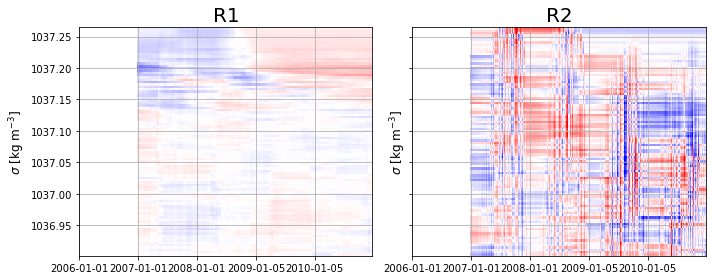

In [22]:
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)#, gridspec_kw={'width_ratios': [2.4,2.4,3]})#, sharex=True)

c = ax0.pcolormesh(anom.R1.time, 
                   anom.R1.sigma2_bin, 
                   anom.R1.T, vmin=-10, vmax=10, cmap='seismic')
ax0.set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
ax0.set_title('R1', fontsize=20)
ax0.set_xticks(anom.dVdt.time.values[year_start_index])
ax0.grid()

c = ax1.pcolormesh(anom.R2.time, 
                   anom.R2.sigma2_bin, 
                   anom.R2.T, vmin=-10, vmax=10, cmap='seismic')
ax1.set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
ax1.set_title('R2', fontsize=20)
ax1.set_xticks(anom.dVdt.time.values[year_start_index])
ax1.grid()
plt.tight_layout();

## Indices

In [30]:
indices

<xarray.Dataset>
Dimensions:          (time: 60)
Coordinates:
  * time             (time) datetime64[ns] 2006-01-01 2006-02-01 ... 2010-12-01
Data variables:
    enso             (time) float32 -0.7034 -0.6278 -0.392 ... -1.47 -1.44
    fw_flx           (time) float32 0.06174 0.3266 -0.6006 ... -0.1008 0.9542
    heat_flx         (time) float32 0.9099 0.5741 0.6695 ... 0.2288 -0.04812
    sam              (time) float64 0.1723 -1.534 1.666 ... 3.167 3.901 0.09625
    sose             (time) float32 -0.1024 -0.3163 -0.7164 ... -0.4328 -0.4636
    windstress_curl  (time) float32 0.1545 0.4456 0.4518 ... -2.025 -0.3768

In [26]:
indices.plot.line(add_legend=True)

AttributeError: '_Dataset_PlotMethods' object has no attribute 'line'